# 시작

In [1]:
import os, numpy
import face_recognition
from PIL import Image

import matplotlib.pyplot as pyplot

# 이미지 전처리, 한번만 수행함

In [2]:
def crop_image(path, file):
    '''
    하나의 이미지 파일에서 얼굴 부분만 추출하여 crops폴더에 저장
    파일은 확장자 없이 이름으로만 저장하여 나중에 이름을 꺼내기 쉽게 함
    파일 형식은 JPEG으로 고정
    
    path : 원본 이미지 저장 폴더, 파일 이름을 포함하지 않음
    file : 원본 이미지 파일 이름, 폴더를 포함하지 않음
    '''
    name = file.split('.')[0]
    crop_path = os.getenv('HOME') + '/aiffel/face_embedding/crops'

    original_image = face_recognition.load_image_file(os.path.join(path, file))
    face_locations = face_recognition.face_locations(original_image)
    if face_locations:  # 얼굴이 있는 경우에만 저장, 얼굴은 하나라고 가정
        a, b, c, d = face_locations[0] 
        cropped_image = original_image[a:c,d:b,:]
        image_array = Image.fromarray(cropped_image)
        image_array.save(os.path.join(crop_path, name), 'JPEG')
        
def crop_images():
    '''
    여러 이미지들에서 얼굴 부분만 추출
    이미지의 폴더는 고정 ~/aiffel/face_embedding/images
    '''
    original_path = os.getenv('HOME') + '/aiffel/face_embedding/images'
    original_files = os.listdir(original_path)
    for file in original_files:
        crop_image(original_path, file)

# 임베딩 생성

In [3]:
def load_face_embedding():
    '''
    여러 이미지들에서 임베딩을 생성
    이미지의 폴더는 고정 ~/aiffel/face_embedding/crops
    '''
    print('임베딩을 생성합니다')
    path = os.getenv('HOME') + '/aiffel/face_embedding/crops'
    files = os.listdir(path)
    embedding = {}
    for file in files:
        image = face_recognition.load_image_file(os.path.join(path, file))
        encodings = face_recognition.face_encodings(image)
        if encodings:
            embedding[file] = encodings[0]
    print('{}개 임베딩이 추출되었습니다'.format(len(embedding)))
    return embedding

# 닮은 이미지 찾기

In [4]:
def get_distance(who, other, embedding):
    '''
    두 사람 이미지 간의 거리를 구함
    
    who       : 기준이 되는 사람
    other     : 거리를 구할 사람
    embedding : {이름:임베딩}
    
    return    : 거리
    '''
    return numpy.linalg.norm(embedding[who]-embedding[other], ord=2)

def get_distance_dic(who, embedding):
    '''
    {이름:임베딩}을 통해 {이름:거리}를 계산, 거리의 기준은 who로 입력 받음
    
    who       : 기준이 되는 사람 이름
    embedding : {이름:임베딩}
    
    return    : {이름:거리}
    '''
    return {name: get_distance(who, name, embedding) for name, e in embedding.items()}

def get_nearest_face(who, embedding, top=5):
    '''
    가장 비슷한 이미지를 찾아 {이름:거리}를 반환함
    
    who : 기준이 되는 사람 이름
    embedding: {이름:임베딩}
    
    return : 가장 비슷한 사람들의 {이름:거리}
    '''
    if who not in embedding.keys():
        print('이미지가 없습니다')
        return
    distance_dic = get_distance_dic(who, embedding) # {이름:임베딩}을 통해 {이름:거리}로 계산
    del distance_dic[who] # 자기 자신 제외
    return sorted(distance_dic.items(), key=lambda x: x[1])[:top]

# 결과 보여주기

In [5]:
def show_image(name):
    '''
    입력된 사람의 사진을 그려줌
    
    name : 사람 이름
    '''
    path = os.getenv('HOME') + '/aiffel/face_embedding/crops'
    image = Image.open(os.path.join(path, name), 'r')
    pyplot.axis('off')
    pyplot.imshow(image)
    pyplot.show()

def show_result(who, nearest_face):
    '''
    찾은 결과를 보여줌
    
    who          : 기준이 되는 사람
    nearest_face : 닯은 사람
    '''
    if not nearest_face:
        return
    show_image(who)
    path = os.getenv('HOME') + '/aiffel/face_embedding/crops'
    
    print('{}와 닮은 사람은'.format(who))
    print('')
    
    pyplot.subplot()
    rank = 1
    for name, distance in nearest_face:
        print('{}위: {}({})'.format(rank, name, distance))
        show_image(name)
        print('')
        rank += 1
        

# 메인

In [6]:
# 새로운 이미지를 추가할 때만 실행
# crop_images()

In [7]:
embedding = load_face_embedding()

임베딩을 생성합니다
396개 임베딩이 추출되었습니다


In [8]:
name = '나'
nearest_face = get_nearest_face(name, embedding)
print('검색 완료')

검색 완료


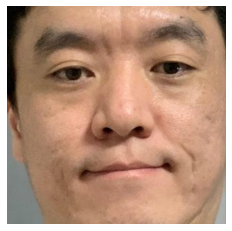

나와 닮은 사람은

1위: 안재욱(0.43230284247786205)


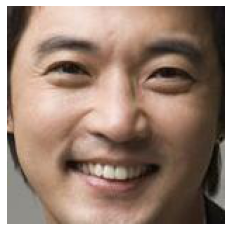


2위: 김영철(0.4399794361891686)


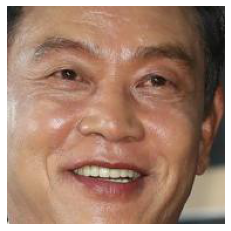


3위: 안내상(0.4454985921831375)


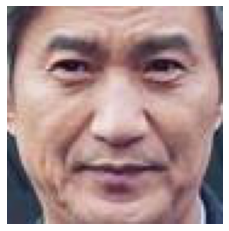


4위: 이원종(0.44590365315362984)


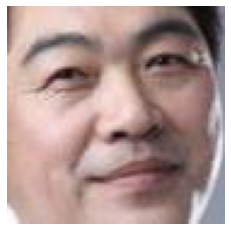


5위: 유해진(0.4527660045450361)


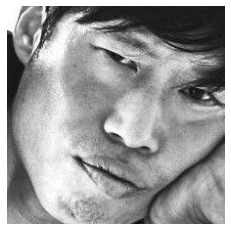

In [9]:
show_result(name, nearest_face)

# 결론

적은 수의 연예인으로는 찾기 어려웠기 때문에 더 많은 연예인 사진을 대상으로 진행하였다.   
남자 연예인의 사진은 나무위키/배우 항목에서 가져왔고, 여러 사람의 협력이 있었다.   
   
살면서 닮았다는 연예인이 없었기 때문에 이번에도 역시 닮은 연예인은 별로 닮지 않았다.   
닮은 순위 1위~5위를 보아도 거리는 0.5이내이지만 그다지 닮은 구석은 없다.   
추측으로는 눈양 끝의 폭, 코의 폭, 입의 좌우 폭의 비율이 어느정도 비슷해서 닮았다고 판단한 것이 아닐까싶다.   
사람이 닮았다고 판단하게 되는 눈매, 눈썹, 입꼬리 등등 세부적인 부분 보다는 더 전체적인 윤곽을 가지고 판단한 것 같다.   

---------------------------------------------

# +AI추천 이상형 월드컵

In [10]:
import random

In [25]:
def show_choices(names):
    '''
    선택지를 보여줌
    
    names : 보여줄 선택지 이름들, [str]
    '''
    path = os.getenv('HOME') + '/aiffel/face_embedding/crops'
    fig, axs = pyplot.subplots(1,len(names), figsize=(12,12))
    for i, name in enumerate(names):
        axs[i].title.set_text(i + 1)
        image = Image.open(os.path.join(path, name), 'r')
        axs[i].axis('off')
        axs[i].imshow(image)
    pyplot.show()
    pyplot.close(fig)

def get_random_choices(embedding, final_choices):
    '''
    전체 embedding 중 무작위로 선택지 5개를 뽑아냄
    
    embedding     : 전체 임베딩
    final_choices : 사용자가 두 번 연속 선택하여 결승에 진출한 선택지, [str]
    
    return        : 생성한 선택지, [str]
    '''
    result = []
    while len(result) < 5:
        name = random.choice(list(embedding.keys()))
        if not (name in result or name in final_choices):
            result.append(name)
    return result

def get_nearest_choices(name, embedding, final_choices):
    '''
    입력된 연예인을 포함하여 닮은 순서로 선택지 5개를 뽑아냄
    
    name          : 입력된 연예인, str
    embedding     : 전체 임베딩
    final_choices : 사용자가 두 번 연속 선택하여 결승에 진출한 선택지, [str]
    
    return        : 생성한 선택지, [str
    '''
    result = [name]
    nearest_face = get_nearest_face(name, embedding, top=10)
    for name, _ in nearest_face:
        if not name in final_choices:
            result.append(name)
        if len(result) == 5:
            break
    random.shuffle(result)
    return result

연예인 중 무작위로 5명을 뽑아내어 그중에 마음에 드는 1명을 뽑는다.   
이전에 뽑은 연예인을 포함하여 닮은 연예인 5명을 뽑아내어 그 중에 마음에 드는 1명을 뽑는다.   
만약 이전에 뽑은 연예인을 다시 선택한다면 결승에 올리고, 다시 무작위로 5명을 뽑아내어 반복한다.   
   
   
이렇게 하면 닯은 사람 중에 더 이상형에 가까운 연예인을 선택하게 되므로 진짜 이상형에 근접한 연예인을 뽑을 수 있지 않을까?

AI추천 이상형 월드컵
예선 시작


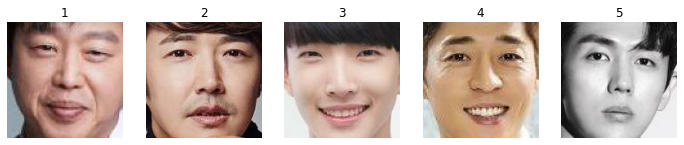

1~5를 입력하여 선택하세요
3


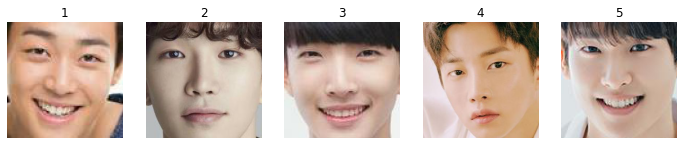

1~5를 입력하여 선택하세요
3


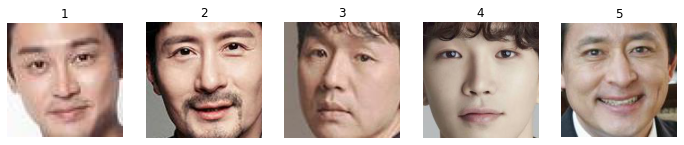

1~5를 입력하여 선택하세요
4


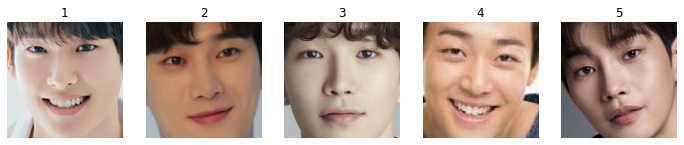

1~5를 입력하여 선택하세요
1


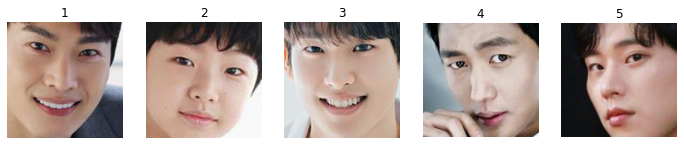

1~5를 입력하여 선택하세요
3
예선 종료

결 승 전


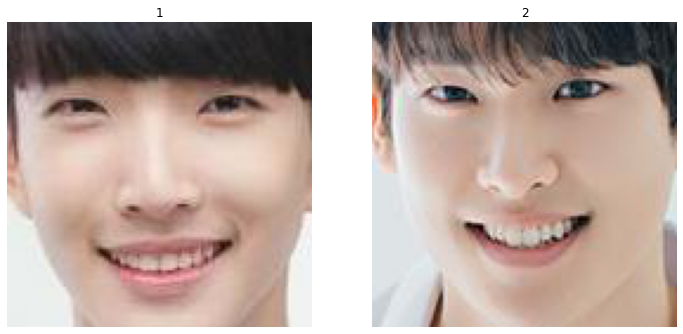

1~2를 입력하여 선택하세요
2


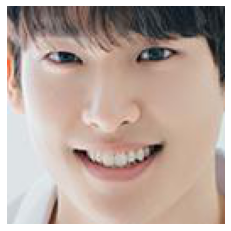

당신의 선택은 김진엽 입니다


In [26]:
final_selection_count = 2  # 결승에 올릴 연예인 수

selections = []       # 사용자의 이전 선택을 담을 곳
final_choices = []    # 사용자가 두 번 연속 선택하면 결승에 진출함. 결승 진출자를 담을 곳
print('AI추천 이상형 월드컵')
print('예선 시작')
while True:
    if selections:    # 사용자의 이전 선택이 있다면 닮은 사람 중에 선택지를 만듦
        choices = get_nearest_choices(selections[0], embedding, final_choices)
    else :            # 사용자의 이전 선택이 없다면 무작위로 선택지를 만듦
        choices = get_random_choices(embedding, final_choices)
    show_choices(choices)

    while True:       # 선택지를 입력 받음
        print('1~5를 입력하여 선택하세요')
        selection = input()
        try:
            i = int(selection)
            if i > 0 and i < 6:
                name = choices[i-1]
                if name in selections:    # 이전에 선택했던 연예인이라면 결승 진출
                    final_choices.append(name)
                    selections.clear()
                else:                     # 새로운 선택이라면 기억해두기
                    selections.clear()
                    selections.append(name)
                break
        except:
            print('잘못된 입력입니다')
            continue
    if len(final_choices) == final_selection_count:   # 결승 선택지가 충분하다면 예선 종료
        print('예선 종료')
        print('')
        break
        
print('결 승 전')
show_choices(final_choices)
while True:
    print('1~{}를 입력하여 선택하세요'.format(final_selection_count))
    selection = input()
    try:
        i = int(selection)
        if i > 0 and i <= final_selection_count:
            winner = final_choices[i-1]
            show_image(winner)
            print('당신의 선택은 {} 입니다'.format(winner))
            break
    except:
        continue
